# 个性化推荐
本项目使用文本卷积神经网络，并使用[`MovieLens`](https://grouplens.org/datasets/movielens/)数据集完成电影推荐的任务。

推荐系统在日常的网络应用中无处不在，比如网上购物，网上买书、新闻app、社交网络、音乐网站、电影网站等等等等，有人的地方就有推荐。根据个人的喜好，相同喜好人群的习惯等信息进行个性化的内容推荐。比如打开新闻类的app，因为有了个性化的内容，每个人看到的新闻首页都是不一样的。

这当然是很有用的，在信息爆炸的今天，获取信息的途径和方式多种多样，人们花费时间最多的不再是去哪获取信息，而是要在众多的信息中寻找自己感兴趣的，这就是信息超载问题。为了解决这个问题，推荐系统应运而生。

协同过滤是推荐系统应用较为广泛的技术，该方法搜集用户的历史纪录、个人喜好等信息，计算与其他用户的相似度，利用相似用户的评价来预测目标用户对特定项目的喜好程度。有点是会给用户推荐未浏览过的项目，缺点呢，对于新用户来说，没有任何与商品的交互记录和个人喜好等信息，存在冷启动问题，导致模型无法找到相似的用户或商品。

为了解决冷启动的问题，通常的做法是对于刚注册的用户，要求用户先选择自己感兴趣的话题、群组、商品、性格、喜欢的音乐类型的信息，比如豆瓣FM。

## 下载数据集
运行下面代码把[数据集](http://files.grouplens.org/datasets/movielens/ml-1m.zip)下载下来

In [1]:
import numpy as np
import os
import pandas as pd
import pickle
import re
import tensorflow as tf

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.python.ops import math_ops

In [2]:
import hashlib
import zipfile

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {} ...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)
        

def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_ML1M = 'ml-1m'
    
    if database_name == DATASET_ML1M:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, 'ml-1m')
        save_path = os.path.join(data_path, 'ml-1m.zip')
        extract_fn = _unzip
    
    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return
    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    
    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(url, save_path, pbar.hook)
    
    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted. Remove the file and try again.'.format(save_path)
    
    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err
    
    print('Done.')
    

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection
        and once after each block read there after
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers
                           which do not return a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [3]:
data_dir = './'
download_extract('ml-1m', data_dir)

Found ml-1m Data


## 先来看看数据
本项目使用的是MovieLens 1M 数据集，包含6000个用户在近4000部电影上的1亿条评论。
数据集分为三个文件：用户数据users.dat，电影数据movies.dat和评分数据ratings.dat。

### 用户数据
分别有用户ID、性别、年龄、职业ID和邮编等字段。

数据中的格式：UserID::Gender::Age::Occupation::Zip-code
- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:
	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"
- Occupation is chosen from the following choices:
	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [4]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine='python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


可以看出UserID、Gender、Age和Occupation都是类别字段，其中邮编字段是我们不使用的。

### 电影数据
分别有电影ID、电影名和电影风格等字段。

数据中的格式：MovieID::Title::Genres
- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:
	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

In [5]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine='python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


MovieID是类别字段，Title是文本，Genres也是类别字段

### 评分数据
分别有用户ID、电影ID、评分和时间戳等字段。

数据中的格式：UserID::MovieID::Rating::Timestamp
- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [6]:
ratings_title = ['UserID', 'MovieID', 'Rating', 'timestamp']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine='python')
ratings.head()

,UserID,MovieID,Rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


评分字段Rating就是我们要学习的targets，时间戳字段我们不使用。

## 来说说数据预处理
- UserID、Occupation和MovieID不用变
- Gender字段：需要将“F”和“M”转换成0和1
- Age字段：要转成7个连续数字0~6
- Genres字段：是分类字段，要转成数字，首先将Genres中的类别转成字符串到数字的字典，然后将每个电影的Genres字段转成数字列表，因为有些电影是多个Genres的组合。
- Title字段：处理方式跟Genres字段一样，首先创建文本到数字的字典，然后将Title中的描述转成数字的列表。另外Title中的年份也需要去掉。
- Genres和Title字段需要将长度统一，这样在神经网络中方便处理。空白部分用< PAD >对应的数字填充

## 实现数据预处理

In [7]:
def load_data():
    """
    Load Dataset from File
    """
    # 读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine='python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    # 改版User数据中性别和奈年龄
    gender_map = {'F': 0, 'M': 1}
    users['Gender'] = users['Gender'].map(gender_map)
    age_map = {val: ii for ii, val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)
    
    # 读取Movie数据集
    movies_title=['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine='python')
    movies_orig = movies.values
    # 将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')
    title_map = {val: pattern.match(val).group(1) for ii, val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)
    
    # 电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)
    
    genres_set.add('<PAD>')
    genres2int = {val: ii for ii, val in enumerate(genres_set)}
    
    # 将电影类型转成等长数字列表，长度是18
    genres_map = {val: [genres2int[row] for row in val.split('|')] for ii, val in enumerate(set(movies['Genres']))}
    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt, genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)
    
    # 电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val: ii for ii, val in enumerate(title_set)}
    
    # 将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val: [title2int[row] for row in val.split()] for ii, val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt, title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)
    
    # 读取评分数据集
    ratings_title = ['UserID', 'MovieID', 'ratings', 'timestamps']
    ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine='python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')
    
    # 合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)
    
    # 将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

### 加载数据并保存到本地
- title_count：Title字段的长度（15）
- title_set：Title文本的集合
- genres2int：电影类型转数字的字典
- features：是输入X
- targets_values：是学习目标y
- ratings：评分数据集的Pandas对象
- users：用户数据集的Pandas对象
- movies：电影数据的Pandas对象
- data：三个数据集组合在一起的Pandas对象
- movies_orig：没有做数据处理的原始电影数据
- users_orig：没有做数据处理的原始用户数据

In [8]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

### 预处理后的数据

In [9]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [10]:
movies.head()

,MovieID,Title,Genres
0,1,"[2511, 1642, 2846, 2846, 2846, 2846, 2846, 284...","[4, 5, 18, 12, 12, 12, 12, 12, 12, 12, 12, 12,..."
1,2,"[1084, 2846, 2846, 2846, 2846, 2846, 2846, 284...","[6, 5, 9, 12, 12, 12, 12, 12, 12, 12, 12, 12, ..."
2,3,"[3687, 4098, 1177, 2846, 2846, 2846, 2846, 284...","[18, 16, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
3,4,"[3199, 1612, 3430, 2846, 2846, 2846, 2846, 284...","[18, 1, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12..."
4,5,"[3044, 5060, 4545, 3922, 257, 2540, 2846, 2846...","[18, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."


In [11]:
movies.values[0]

array([1,
       list([2511, 1642, 2846, 2846, 2846, 2846, 2846, 2846, 2846, 2846, 2846, 2846, 2846, 2846, 2846]),
       list([4, 5, 18, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12])],
      dtype=object)

### 从本地读取数据

In [12]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

## 模型设计
通过研究数据集中的字段类型，我们发现有一些是类别字段，通常的处理是将这些字段转成one hot编码，但是像UserID、MovieID这样的字段就会变成非常的稀疏，输入的维度急剧膨胀，这是我们不愿意见到的，毕竟我们的电脑不像大厂动辄能处理数以亿计维度的输入:)

所以在与处理数据时将这些字段转成了数字，我们用这个数字当作嵌入矩阵的索引，在网络的第一层使用了嵌入层，维度是(N，32)和(N，16)

电影类型的处理要多一步，有时一个电影有多个电影类型，这样从嵌入矩阵索引出来是一个(n, 32)的矩阵，因为有多个类型嘛，我们要将这个矩阵求和，变成(1,32)的向量。

电影名的处理比较特殊，没有使用循环神经网络，而是用了文本卷积网络，下文会进行说明。

从嵌入层索引出特征以后，将各特征传入全连接层，将输出再次传入全连接层，最终分别得到(1, 200)的用户特征和电影特征两个特征向量。

我们的目的就是要训练出用户特征和电影特征，在实现推荐功能时使用。得到这两个特征以后，就可以选择任意的方式来拟合评分了。我使用了两种方式，一个是将两个特征向量做乘法，将结果与真实评分做回归，采用MSE优化损失。因为本质上这是一个回归问题，另一种方式是，将两个特征作为输入，再次传入全连接层，输出一个值，将输出值回归到真实评分，采用MSE优化损失。

实际上第二个方式的MSE loss在0.8附近，第一个方式在1附近，5次迭代的结果。

## 文本卷积网络
网络的第一层是词嵌入层，由每一个单词的嵌入向量组成的嵌入矩阵。下一层使用多个不同尺寸的卷积核在嵌入矩阵上做卷积，窗口大小指的是每次卷积覆盖几个单词。这里跟对图像做卷积不太一样，图像的卷积通常用2x2、3x3、5x5之类的尺寸，而文本卷积要覆盖整个单词的嵌入向量，所以尺寸是（单词数、向量维度），比如每次滑动3个、4个或者5个单词。第三层网络是max pooling得到一个常相良，最后使用dropout做正则化，最终得到了电影Title的特征。

## 辅助函数

In [13]:
import os
import pickle
import tensorflow as tf


def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))
    

def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', 'rb'))

## 编码实现

In [14]:
# 嵌入矩阵的维度
embed_dim = 32
# 用户ID个数
uid_max = max(features.take(0, 1)) + 1  # 6040
# 性别个数
gender_max = max(features.take(2, 1)) + 1  # 2
# 年龄类别个数
age_max = max(features.take(3, 1)) + 1  # 7
# 职业个数
job_max = max(features.take(4, 1)) + 1  # 21

# 电影ID个数
movie_id_max = max(features.take(1, 1)) + 1  #3952
# 电影类型个数
movie_categories_max = max(genres2int.values()) + 1  # 19
# 电影名单词个数
movie_title_max = len(title_set)  # 5216

# 对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = 'sum'

# 电影名长度
sentences_size = title_count  # 15
# 文本卷积滑动窗口，分别华东2，3，4，5个单词
# window_sizes = [2, 3, 4, 5]
# 文本卷积核数量
filter_num = 8

# 电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

### 超参

In [15]:
num_epochs = 5
batch_size = 256
dropout_keep = 0.5
learning_rate = 0.0001
show_every_n_batches = 20
save_dir = './save'

### 输入
定义输入的占位符

In [16]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name='uid')
    movie_id = tf.placeholder(tf.int32, [None, 1], name='movie_id')
    movie_categories = tf.placeholder(tf.int32, [None, 18], name='movie_categories')
    movie_titles = tf.placeholder(tf.int32, [None, 15], name='movie_titles')
    targets = tf.placeholder(tf.int32, [None, 1], name='targets')
    LearningRate = tf.placeholder(tf.float32, name='LearningRate')
    dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')
    return uid, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

## 构建神经网络
#### 定义User的嵌入矩阵

In [17]:
def get_uid_embed_layer(uid):
    with tf.name_scope('user_embedding'):
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name='uid_embed_matrix')
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name='uid_embed_layer')
    return uid_embed_layer

#### 将User的嵌入矩阵一起全连接生成User的特征

In [18]:
def get_user_feature_layer(uid_embed_layer):
    with tf.name_scope('user_fc'):
        # 第一层全连接
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name='uid_fc_layer')
        
        # 第二层全连接
        user_combine_layer = tf.contrib.layers.fully_connected(uid_fc_layer, 200, tf.tanh)
        
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
        
    return user_combine_layer, user_combine_layer_flat

#### 定义Movie ID的嵌入矩阵

In [19]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope('movie_embedding'):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name='movie_id_embed_matrix')
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name='movie_id_embed_layer')
    return movie_id_embed_layer

#### 对电影类型的多个嵌入向量做加和

In [20]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope('movie_categories_layers'):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name='movie_categories_embed_matrix')
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name='movie_categories_embed_layer')
        if combiner == 'sum':
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    return movie_categories_embed_layer

#### Movie Title的文本卷积网络实现

In [21]:
def get_movie_cnn_layer(movie_titles):
    # 从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope('movie_embedding'):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name='movie_title_embed_matrix')
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name='movie_title_embed_layer')
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    # 对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope('movie_txt_conv_maxpool_{}'.format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num], stddev=0.1), name='filter_weights')
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name='filter_bias')
            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1, 1, 1, 1], padding='VALID', name='conv_layer')
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer, filter_bias), name='relu_layer')
            maxpool_layer = tf.nn.max_pool(relu_layer, [1, sentences_size-window_size+1, 1, 1], [1, 1, 1, 1], padding='VALID', name='maxpool_layer')
            pool_layer_lst.append(maxpool_layer)
        
    # Dropout层
    with tf.name_scope('pool_dropout'):
        pool_layer = tf.concate(pool_layer_lst, 3, name='pool_layer')
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer, [-1, 1, max_num], name = 'pool_layer_flat')
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name='dropout_layer')
    return pool_layer_flat, dropout_layer
            

#### 将Movie的各个层一起做全连接

In [22]:
def get_movie_feature_layer(movie_id_embed_layer):
    with tf.name_scope('movie_fc'):
        # 第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name='movie_id_fc_layer', activation=tf.nn.relu)
        # 第二层全连接
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_id_fc_layer, 200, tf.tanh)
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

## 构建计算图

In [23]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    # 获取输入占位符
    uid, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    # 获取User的4个嵌入想浪
    uid_embed_layer = get_uid_embed_layer(uid)
    # 得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer)
    # 获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    # 得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer)
    # 计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope('inference'):
        # 将用户特征和电影特征作为输入，经过全连接，输出一个值得方案
        # 简单地将用户特征和电影特征做矩阵乘法得到一个预测评分
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)
    with tf.name_scope('loss'):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference)
        loss = tf.reduce_sum(cost)
    # 优化损失
    global_step = tf.Variable(0, name='global_step', trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)

In [24]:
inference

<tf.Tensor 'inference/ExpandDims:0' shape=(?, 1) dtype=float32>

## 取得batch

In [25]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

In [26]:
## 训练网络
import datetime
import matplotlib.pyplot as plt
import time
%matplotlib inline
%config InlineBackend.figure_format='retina'

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    # 搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram('{}/grad/hist'.format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar('{}/grad/sparsity'.format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
    
    # Ooutput directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, 'runs', timestamp))
    print('Writing to {}\n'.format(out_dir))
    
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar('loss', loss)
    
    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, 'summaries', 'train')
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)
    
    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, 'summaries', 'inference')
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        # 将数据集分成训练集和测试机，随机种子不固定
        train_X, test_X, train_y, test_y = train_test_split(features, targets_values, test_size=0.2, random_state=0)
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
        
        # 训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6, 1)[i]
            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5, 1)[i]
            
            feed = {uid: np.reshape(x.take(0, 1), [batch_size, 1]),
                    movie_id: np.reshape(x.take(1, 1), [batch_size, 1]),
                    movie_categories: categories,
                    movie_titles: titles,
                    targets: np.reshape(y, [batch_size, 1]),
                    dropout_keep_prob: dropout_keep,
                    lr: learning_rate}
            
            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)
            
            # Show every (show_every_n_batches) batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{} train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss
                ))
                
        # 使用测试数据的迭代
        for batch_i in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6, 1)[i]
            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5, 1)[i]
            
            feed = {uid: np.reshape(x.take(0, 1), [batch_size, 1]),
                    movie_id: np.reshape(x.take(1, 1), [batch_size, 1]),
                    movie_categories: categories,
                    movie_titles: titles,
                    targets: np.reshape(y, [batch_size, 1]),
                    dropout_keep_prob: dropout_keep,
                    lr: learning_rate}
            
            step, test_loss, summaries= sess.run([global_step, loss, inference_summary_op], feed)
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)
            
            # Show every (show_every_n_batches) batches
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{} test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss
                ))
    # Save Model
    saver.save(sess, save_dir)
    print('Model Trained and Saved')

Writing to C:\Users\Administrator\PycharmProjects\pynb\runs\1544082093

2018-12-06T15:41:34.472485: Epoch   0 Batch    0/3125 train_loss = 14.626
2018-12-06T15:41:34.724809: Epoch   0 Batch   20/3125 train_loss = 14.653
2018-12-06T15:41:34.975295: Epoch   0 Batch   40/3125 train_loss = 14.008
2018-12-06T15:41:35.228249: Epoch   0 Batch   60/3125 train_loss = 13.170
2018-12-06T15:41:35.482568: Epoch   0 Batch   80/3125 train_loss = 13.687
2018-12-06T15:41:35.742871: Epoch   0 Batch  100/3125 train_loss = 12.749
2018-12-06T15:41:35.994198: Epoch   0 Batch  120/3125 train_loss = 13.170
2018-12-06T15:41:36.251917: Epoch   0 Batch  140/3125 train_loss = 12.457
2018-12-06T15:41:36.503455: Epoch   0 Batch  160/3125 train_loss = 12.091
2018-12-06T15:41:36.757901: Epoch   0 Batch  180/3125 train_loss = 11.430
2018-12-06T15:41:37.011478: Epoch   0 Batch  200/3125 train_loss = 9.537
2018-12-06T15:41:37.275770: Epoch   0 Batch  220/3125 train_loss = 9.043
2018-12-06T15:41:37.616857: Epoch   0 Batc

2018-12-06T15:42:03.506545: Epoch   0 Batch 2220/3125 train_loss = 1.190
2018-12-06T15:42:03.763855: Epoch   0 Batch 2240/3125 train_loss = 1.106
2018-12-06T15:42:04.020169: Epoch   0 Batch 2260/3125 train_loss = 1.243
2018-12-06T15:42:04.282467: Epoch   0 Batch 2280/3125 train_loss = 1.214
2018-12-06T15:42:04.539777: Epoch   0 Batch 2300/3125 train_loss = 1.208
2018-12-06T15:42:04.792360: Epoch   0 Batch 2320/3125 train_loss = 1.325
2018-12-06T15:42:05.042056: Epoch   0 Batch 2340/3125 train_loss = 1.219
2018-12-06T15:42:05.293383: Epoch   0 Batch 2360/3125 train_loss = 1.249
2018-12-06T15:42:05.546704: Epoch   0 Batch 2380/3125 train_loss = 1.268
2018-12-06T15:42:05.798032: Epoch   0 Batch 2400/3125 train_loss = 1.273
2018-12-06T15:42:06.044372: Epoch   0 Batch 2420/3125 train_loss = 1.120
2018-12-06T15:42:06.292365: Epoch   0 Batch 2440/3125 train_loss = 1.304
2018-12-06T15:42:06.545209: Epoch   0 Batch 2460/3125 train_loss = 1.145
2018-12-06T15:42:06.798037: Epoch   0 Batch 2480/31

2018-12-06T15:42:26.975971: Epoch   1 Batch  555/3125 train_loss = 1.290
2018-12-06T15:42:27.232285: Epoch   1 Batch  575/3125 train_loss = 1.088
2018-12-06T15:42:27.480619: Epoch   1 Batch  595/3125 train_loss = 1.325
2018-12-06T15:42:27.724947: Epoch   1 Batch  615/3125 train_loss = 1.041
2018-12-06T15:42:27.969292: Epoch   1 Batch  635/3125 train_loss = 1.140
2018-12-06T15:42:28.235579: Epoch   1 Batch  655/3125 train_loss = 1.110
2018-12-06T15:42:28.491894: Epoch   1 Batch  675/3125 train_loss = 0.932
2018-12-06T15:42:28.746211: Epoch   1 Batch  695/3125 train_loss = 1.133
2018-12-06T15:42:28.994354: Epoch   1 Batch  715/3125 train_loss = 1.095
2018-12-06T15:42:29.246679: Epoch   1 Batch  735/3125 train_loss = 1.106
2018-12-06T15:42:29.493426: Epoch   1 Batch  755/3125 train_loss = 1.168
2018-12-06T15:42:29.740764: Epoch   1 Batch  775/3125 train_loss = 1.052
2018-12-06T15:42:29.986107: Epoch   1 Batch  795/3125 train_loss = 1.145
2018-12-06T15:42:30.240426: Epoch   1 Batch  815/31

2018-12-06T15:42:55.188960: Epoch   1 Batch 2795/3125 train_loss = 1.110
2018-12-06T15:42:55.443788: Epoch   1 Batch 2815/3125 train_loss = 1.047
2018-12-06T15:42:55.695114: Epoch   1 Batch 2835/3125 train_loss = 1.124
2018-12-06T15:42:55.941467: Epoch   1 Batch 2855/3125 train_loss = 1.105
2018-12-06T15:42:56.189793: Epoch   1 Batch 2875/3125 train_loss = 1.047
2018-12-06T15:42:56.437638: Epoch   1 Batch 2895/3125 train_loss = 1.006
2018-12-06T15:42:56.688452: Epoch   1 Batch 2915/3125 train_loss = 1.010
2018-12-06T15:42:56.939780: Epoch   1 Batch 2935/3125 train_loss = 1.122
2018-12-06T15:42:57.191107: Epoch   1 Batch 2955/3125 train_loss = 1.076
2018-12-06T15:42:57.446927: Epoch   1 Batch 2975/3125 train_loss = 0.974
2018-12-06T15:42:57.699252: Epoch   1 Batch 2995/3125 train_loss = 1.021
2018-12-06T15:42:57.954041: Epoch   1 Batch 3015/3125 train_loss = 0.998
2018-12-06T15:42:58.206366: Epoch   1 Batch 3035/3125 train_loss = 1.038
2018-12-06T15:42:58.455699: Epoch   1 Batch 3055/31

2018-12-06T15:43:19.586247: Epoch   2 Batch 1150/3125 train_loss = 0.999
2018-12-06T15:43:19.868492: Epoch   2 Batch 1170/3125 train_loss = 1.024
2018-12-06T15:43:20.144752: Epoch   2 Batch 1190/3125 train_loss = 1.058
2018-12-06T15:43:20.438984: Epoch   2 Batch 1210/3125 train_loss = 0.923
2018-12-06T15:43:20.746161: Epoch   2 Batch 1230/3125 train_loss = 0.885
2018-12-06T15:43:21.014443: Epoch   2 Batch 1250/3125 train_loss = 0.988
2018-12-06T15:43:21.273749: Epoch   2 Batch 1270/3125 train_loss = 1.096
2018-12-06T15:43:21.532680: Epoch   2 Batch 1290/3125 train_loss = 0.904
2018-12-06T15:43:21.792996: Epoch   2 Batch 1310/3125 train_loss = 1.038
2018-12-06T15:43:22.041837: Epoch   2 Batch 1330/3125 train_loss = 1.089
2018-12-06T15:43:22.293165: Epoch   2 Batch 1350/3125 train_loss = 0.913
2018-12-06T15:43:22.538507: Epoch   2 Batch 1370/3125 train_loss = 0.844
2018-12-06T15:43:22.783851: Epoch   2 Batch 1390/3125 train_loss = 1.085
2018-12-06T15:43:23.030413: Epoch   2 Batch 1410/31

2018-12-06T15:43:46.974209: Epoch   2 Batch  278/781 test_loss = 1.071
2018-12-06T15:43:47.087905: Epoch   2 Batch  298/781 test_loss = 0.961
2018-12-06T15:43:47.203594: Epoch   2 Batch  318/781 test_loss = 0.898
2018-12-06T15:43:47.323275: Epoch   2 Batch  338/781 test_loss = 0.931
2018-12-06T15:43:47.439962: Epoch   2 Batch  358/781 test_loss = 0.929
2018-12-06T15:43:47.555653: Epoch   2 Batch  378/781 test_loss = 0.962
2018-12-06T15:43:47.672342: Epoch   2 Batch  398/781 test_loss = 0.908
2018-12-06T15:43:47.786389: Epoch   2 Batch  418/781 test_loss = 1.006
2018-12-06T15:43:47.897093: Epoch   2 Batch  438/781 test_loss = 1.057
2018-12-06T15:43:48.008794: Epoch   2 Batch  458/781 test_loss = 0.981
2018-12-06T15:43:48.118500: Epoch   2 Batch  478/781 test_loss = 0.977
2018-12-06T15:43:48.235779: Epoch   2 Batch  498/781 test_loss = 0.825
2018-12-06T15:43:48.345998: Epoch   2 Batch  518/781 test_loss = 0.921
2018-12-06T15:43:48.459193: Epoch   2 Batch  538/781 test_loss = 0.921
2018-1

2018-12-06T15:44:12.166496: Epoch   3 Batch 1725/3125 train_loss = 0.876
2018-12-06T15:44:12.420982: Epoch   3 Batch 1745/3125 train_loss = 0.863
2018-12-06T15:44:12.677296: Epoch   3 Batch 1765/3125 train_loss = 0.877
2018-12-06T15:44:12.927422: Epoch   3 Batch 1785/3125 train_loss = 1.031
2018-12-06T15:44:13.178762: Epoch   3 Batch 1805/3125 train_loss = 1.015
2018-12-06T15:44:13.427096: Epoch   3 Batch 1825/3125 train_loss = 1.065
2018-12-06T15:44:13.678423: Epoch   3 Batch 1845/3125 train_loss = 1.005
2018-12-06T15:44:13.925761: Epoch   3 Batch 1865/3125 train_loss = 0.867
2018-12-06T15:44:14.177087: Epoch   3 Batch 1885/3125 train_loss = 0.955
2018-12-06T15:44:14.426420: Epoch   3 Batch 1905/3125 train_loss = 0.881
2018-12-06T15:44:14.677746: Epoch   3 Batch 1925/3125 train_loss = 0.870
2018-12-06T15:44:14.935058: Epoch   3 Batch 1945/3125 train_loss = 0.948
2018-12-06T15:44:15.184390: Epoch   3 Batch 1965/3125 train_loss = 0.832
2018-12-06T15:44:15.437106: Epoch   3 Batch 1985/31

2018-12-06T15:44:35.651921: Epoch   4 Batch   80/3125 train_loss = 0.909
2018-12-06T15:44:35.899259: Epoch   4 Batch  100/3125 train_loss = 0.970
2018-12-06T15:44:36.147594: Epoch   4 Batch  120/3125 train_loss = 0.988
2018-12-06T15:44:36.398430: Epoch   4 Batch  140/3125 train_loss = 0.941
2018-12-06T15:44:36.644772: Epoch   4 Batch  160/3125 train_loss = 0.829
2018-12-06T15:44:36.893106: Epoch   4 Batch  180/3125 train_loss = 0.887
2018-12-06T15:44:37.140444: Epoch   4 Batch  200/3125 train_loss = 1.107
2018-12-06T15:44:37.391761: Epoch   4 Batch  220/3125 train_loss = 0.928
2018-12-06T15:44:37.638611: Epoch   4 Batch  240/3125 train_loss = 0.990
2018-12-06T15:44:37.885949: Epoch   4 Batch  260/3125 train_loss = 0.997
2018-12-06T15:44:38.135282: Epoch   4 Batch  280/3125 train_loss = 0.974
2018-12-06T15:44:38.388603: Epoch   4 Batch  300/3125 train_loss = 1.094
2018-12-06T15:44:38.636941: Epoch   4 Batch  320/3125 train_loss = 1.007
2018-12-06T15:44:38.882284: Epoch   4 Batch  340/31

2018-12-06T15:45:04.141528: Epoch   4 Batch 2320/3125 train_loss = 0.918
2018-12-06T15:45:04.403841: Epoch   4 Batch 2340/3125 train_loss = 0.881
2018-12-06T15:45:04.652176: Epoch   4 Batch 2360/3125 train_loss = 0.900
2018-12-06T15:45:04.901508: Epoch   4 Batch 2380/3125 train_loss = 0.906
2018-12-06T15:45:05.147849: Epoch   4 Batch 2400/3125 train_loss = 0.957
2018-12-06T15:45:05.402195: Epoch   4 Batch 2420/3125 train_loss = 0.783
2018-12-06T15:45:05.649715: Epoch   4 Batch 2440/3125 train_loss = 0.850
2018-12-06T15:45:05.900044: Epoch   4 Batch 2460/3125 train_loss = 0.878
2018-12-06T15:45:06.152369: Epoch   4 Batch 2480/3125 train_loss = 1.008
2018-12-06T15:45:06.400704: Epoch   4 Batch 2500/3125 train_loss = 0.886
2018-12-06T15:45:06.647044: Epoch   4 Batch 2520/3125 train_loss = 0.906
2018-12-06T15:45:06.892387: Epoch   4 Batch 2540/3125 train_loss = 0.894
2018-12-06T15:45:07.147703: Epoch   4 Batch 2560/3125 train_loss = 0.704
2018-12-06T15:45:07.410001: Epoch   4 Batch 2580/31

## 在TensorBoard中查看可视化结果
tensorboard --logdir /PATH_TO_CODE/runs/timestamp/summaries
## 保存参数
保存save_dir在生成预测时使用。

In [27]:
save_params((save_dir))

load_dir = load_params()

## 显示训练Loss

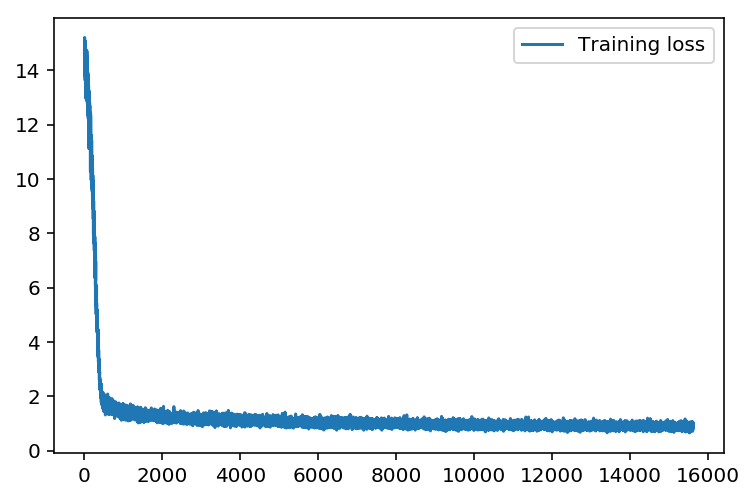

In [28]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 显示测试Loss
迭代次数再增加一些，下降的趋势会明显一些

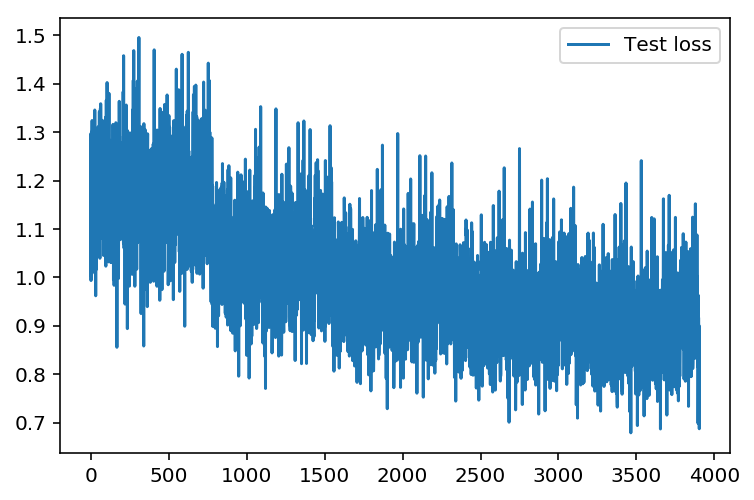

In [29]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 获取Tensor
使用函数`get_tensor_by_name()`从`loaded_graph`中获取tensors，后面的推荐功能要用到。

In [30]:
def get_tensors(loaded_graph):
    uid = loaded_graph.get_tensor_by_name('uid:0')
    movie_id = loaded_graph.get_tensor_by_name('movie_id:0')
    movie_categories = loaded_graph.get_tensor_by_name('movie_categories:0')
    movie_titles = loaded_graph.get_tensor_by_name('movie_titles:0')
    targets = loaded_graph.get_tensor_by_name('targets:0')
    dropout_keep_prob = loaded_graph.get_tensor_by_name('dropout_keep_prob:0')
    lr = loaded_graph.get_tensor_by_name('LearningRate:0')
    inference = loaded_graph.get_tensor_by_name('inference/ExpandDims:0')
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name('movie_fc/Reshape:0')
    user_combine_layer_flat = loaded_graph.get_tensor_by_name('user_fc/Reshape:0')
    return uid, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat

## 指定用户和电影进行评分
这部分就是对网络做正向传播，计算得到预测的评分

In [31]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        # Get Tensors from loaded model
        uid, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, _, _ = get_tensors(loaded_graph)
        
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
        
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
        
        feed = {uid: np.reshape(users.values[user_id_val - 1][0], [1, 1]),
                movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
                movie_categories: categories,
                movie_titles: titles,
                dropout_keep_prob: 1}
        
        # Get prediction
        inference_val = sess.run([inference], feed)
        
        return (inference_val)

In [32]:
rating_movie(234, 1401)

INFO:tensorflow:Restoring parameters from ./save


[array([[3.5976136]], dtype=float32)]

## 生成Movie特征矩阵
将训练好的电影特征组合成电影特征矩阵并保存到本地

In [33]:
loaded_graph = tf.Graph()
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    
    # Get Tensors from loaded model
    uid, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, _ = get_tensors(loaded_graph)
    
    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)
        
        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)
        
        feed = {movie_id: np.reshape(item.take(0), [1, 1]),
                movie_categories: categories,
                movie_titles: titles,
                dropout_keep_prob: 1}
        
        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)
        movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [34]:
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

## 生成User特征矩阵
将训练好的用户特征组合成用户特征矩阵并保存到本地

In [35]:
loaded_graph = tf.Graph()
user_matrics = []
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    
    # Get Tensors from loaded model
    uid, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, _, user_combine_layer_flat = get_tensors(loaded_graph)
    
    
    for item in users.values:
        feed = {uid: np.reshape(item.take(0), [1, 1]),
                dropout_keep_prob: 1}
        
        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)
        user_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(user_matrics).reshape(-1, 200)), open('user_matrics.p', 'wb'))
user_matrics = pickle.load(open('user_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [36]:
user_matrics = pickle.load(open('user_matrics.p', mode='rb'))

## 开始推荐电影
使用生产的用户特征矩阵和电影特征矩阵做电影推荐

### 推荐同类型的电影
思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择再里面，保证每次的推荐稍稍有些不同

In [37]:
def recommend_same_type_movie(movie_id_val, top_k=20):
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics
        
        # 推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
        
        print('您看的电影是：{}'.format(movies_orig[movieid2idx[movie_id_val]]))
        print('以下是给您推荐的：')
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p/ np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
    
        return results

In [38]:
recommend_same_type_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
Instructions for updating:
keep_dims is deprecated, use keepdims instead
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您推荐的：
3457
[3526 'Parenthood (1989)' 'Comedy|Drama']
1380
[1401 'Ghosts of Mississippi (1996)' 'Drama']
3629
[3698 'Running Man, The (1987)' 'Action|Adventure|Sci-Fi']
3024
[3093 'McCabe & Mrs. Miller (1971)' 'Drama|Western']
954
[966 'Walk in the Sun, A (1945)' 'Drama']


{954, 1380, 3024, 3457, 3629}

### 推荐您喜欢的电影
思路是使用用户特征向量和电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加入了些随机选择部分。

In [39]:
def recommend_your_favorite_movie(user_id_val, top_k=10):
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        # 推荐您喜欢的电影
        probs_embeddings = (user_matrics[user_id_val - 1]).reshape([1, 200])
        
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
        
        print('以下是给您的推荐：')
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        return results

In [40]:
recommend_your_favorite_movie(234, 10)

INFO:tensorflow:Restoring parameters from ./save
以下是给您的推荐：
2469
[2538 'Dancemaker (1998)' 'Documentary']
1803
[1872 'Go Now (1995)' 'Drama']
911
[923 'Citizen Kane (1941)' 'Drama']
1180
[1198 'Raiders of the Lost Ark (1981)' 'Action|Adventure']
1950
[2019
 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'
 'Action|Drama']


{911, 1180, 1803, 1950, 2469}

### 看过这个电影的人还看了（喜欢）哪些电影
- 首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
- 然后计算这几个人对所有电影的评分
- 选择每个人评分最高的电影作为推荐
- 同样加入了随机选择

In [41]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k=10):
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        # 推荐您喜欢的电影
        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(user_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
        
        print('您看的电影是：{}'.format(movies_orig[movieid2idx[movie_id_val]]))
        print('喜欢看这个电影的人是：{}'.format(users_orig[favorite_user_id - 1]))
        probs_users_embeddings = (user_matrics[favorite_user_id - 1]).reshape([-1, 200])
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
                                     
        p = np.argmax(sim, 1)
        print('喜欢看这个电影的人还喜欢看')
        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        return results

In [42]:
recommend_other_favorite_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[5203 'F' 45 6]
 [4888 'F' 56 0]
 [4189 'M' 35 14]
 [155 'M' 35 12]
 [3763 'M' 25 2]
 [4884 'M' 35 14]
 [520 'F' 35 20]
 [2823 'M' 25 4]
 [5503 'F' 25 9]
 [2902 'M' 25 12]
 [4562 'M' 35 10]
 [3347 'F' 35 7]
 [2546 'F' 56 13]
 [1752 'M' 25 3]
 [4272 'M' 45 17]
 [52 'M' 18 4]
 [2737 'M' 25 3]
 [4903 'M' 35 12]
 [724 'M' 50 13]
 [3031 'M' 18 4]]
喜欢看这个电影的人还喜欢看


KeyboardInterrupt: 

## 结论
以上就是实现的常用的推荐功能，将网络模型作为回归问题进行训练，得到训练好的用户特征矩阵和电影特征矩阵进行推荐。

### 扩展阅读
如果你对个性化推荐感兴趣，以下资料建议你看看：
- [`Understanding Convolutional Neural Networks for NLP`](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

- [`Convolutional Neural Networks for Sentence Classification`](https://github.com/yoonkim/CNN_sentence)

- [`利用TensorFlow实现卷积神经网络做文本分类`](http://www.jianshu.com/p/ed3eac3dcb39?from=singlemessage)

- [`Convolutional Neural Network for Text Classification in Tensorflow`](https://github.com/dennybritz/cnn-text-classification-tf)

- [`SVD Implement Recommendation systems`](https://github.com/songgc/TF-recomm)